In [1]:
import os
import sys

sys.path.append("./")  # Adds higher directory to python modules path.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from data_pipeline import *
import numpy as np
import pandas as pd
from core.ODEDataset import  ODEDataset
from utils import cleaning

In [2]:
print("Available devices:", tf.config.list_physical_devices())
logical_devices = tf.config.list_logical_devices()
print("Active logical devices:", logical_devices)

print("Version : ", tf.__version__)

Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Active logical devices: [LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
Version :  2.11.0


Let's load the dataset and  select the columns we want to use as features and labels.

## Constants & Parameters

In [3]:
BATCH_SIZE = 4096
Features = ['Years_of_HHH_in_community',
 'Dwelling_quality_index',
 'Hours_available_electricity',
 'Measurement_age',
 'Monthly_expenditure',
 'Number_of_rooms',
 'Climate_zone_lev_1',
 'Climate_zone_lev_2',
 'Age_HHH',
 'Number_adults',
 'HH_with_home_business_No',
 'HH_with_home_business_Yes',
 'Education_level_HHH_No schooling',
 'Education_level_HHH_Not classified',
 'Education_level_HHH_Primary',
 'Education_level_HHH_Secondary',
 'Education_level_HHH_Tertiary',
 'Socio_status_HHH_Employer',
 'Socio_status_HHH_Other',
 'Socio_status_HHH_Unemployed',
 'Socio_status_HHH_Worker',
 'Ownership_motorized_vehicle_No',
 'Ownership_motorized_vehicle_Yes',
 'Ownership_small_livestock_No',
 'Ownership_small_livestock_Yes',
 'Ownership_large_livestock_No',
 'Ownership_large_livestock_Yes',
 'Clean_fuel_No',
 'Clean_fuel_Yes',
 'Tariff_payment_frequency_Monthly or More',
 'Tariff_payment_frequency_Weekly or More',
 'Tariff_payment_frequency_other']
FEATURE_NUM = len(Features)



In [4]:
# OUTPUT =  "Presence_refrigerator/freezer"
OUTPUT =  "Presence_iron" 
# OUTPUT =  "Presence_fan" 
# OUTPUT =  "Presence_DVD_player" 
# OUTPUT =  "Presence_radio/stereo"
# OUTPUT =  "Presence_phone_charger" 
# OUTPUT =  "Presence_TV" 

In [5]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
sampler = RandomOverSampler()

## Dataset and Feature Selection

In [6]:
train_dataset = ODEDataset("train_ds")
train_dataset.from_csv("./playground/data/normalized_train_set.csv", )
train_dataset = train_dataset.apply(cleaning.remove_row(OUTPUT, -1))

val_dataset = ODEDataset("val_ds")
val_dataset.from_csv("./playground/data/normalized_val_set.csv", )
val_dataset = val_dataset.apply(cleaning.remove_row(OUTPUT, -1))

test_dataset = ODEDataset("test_ds")
test_dataset.from_csv("./playground/data/normalized_test_set.csv", )
test_dataset = test_dataset.apply(cleaning.remove_row(OUTPUT, -1))


In [7]:
x_train, y_train = train_dataset.to_numpy(Features, OUTPUT)
x_val, y_val = val_dataset.to_numpy(Features, OUTPUT)
x_test, y_test = test_dataset.to_numpy(Features, OUTPUT)

### Imbalanced Dataset Handling
We use Imbalanced learning library 
https://imbalanced-learn.org/stable/index.html

In [8]:
x_train, y_train = sampler.fit_resample(x_train, y_train )
x_val, y_val = sampler.fit_resample(x_val, y_val )
print(x_train.shape, y_train.shape)

(8102, 32) (8102,)


<BarContainer object of 2 artists>

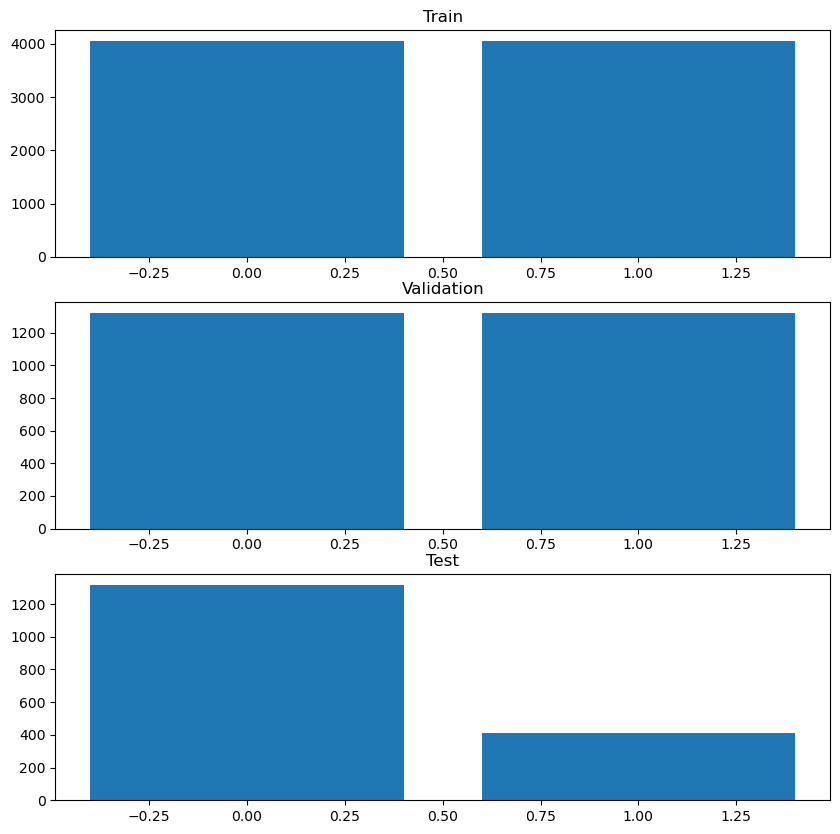

In [9]:
from collections import Counter
plt.figure(figsize=(10, 10))
cnt = Counter(y_train)
plt.subplot(3, 1, 1)
plt.title("Train")
plt.bar(cnt.keys(), cnt.values())

plt.subplot(3, 1, 2)
cnt = Counter(y_val)
plt.title("Validation")
plt.bar(cnt.keys(), cnt.values())


plt.subplot(3, 1, 3)
cnt = Counter(y_test)
plt.title("Test")
plt.bar(cnt.keys(), cnt.values())





In [10]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train.astype(np.float32), y_train.astype(np.float32)))

train_ds = train_ds.shuffle(10010).batch(BATCH_SIZE)

val_ds = tf.data.Dataset.from_tensor_slices((x_val.astype(np.float32), y_val.astype(np.float32)))

val_ds = val_ds.shuffle(10010).batch(BATCH_SIZE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test.astype(np.float32), y_test.astype(np.float32)))



## Model

In [11]:
def residual_block(input_tensor, units, activation=tf.keras.layers.ReLU(),dropout=0.1, bn=True, regularizer=None):
    # First layer in the block
    x = tf.keras.layers.Dense(units, kernel_regularizer=regularizer)(input_tensor)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation)(x)
    
    # Second layer in the block
    x = tf.keras.layers.Dense(units, kernel_regularizer=regularizer)(x)
    if bn:
        
        x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Dropout(dropout)(x)
    # Skip connection (adding input to output)
    x = tf.keras.layers.Add()([x, input_tensor])
    x = activation(x)  # Activation after addition
    return x

def layer_block(x, units, activation=tf.keras.layers.ReLU(),dropout=0.1, bn=True, regularizer=None):
    x = tf.keras.layers.Dense(units, kernel_regularizer=regularizer)(x)
    
    if bn:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Dropout(dropout)(x)
    x = activation(x)
    return x


In [12]:
THRESHOLD = 0.5
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.001)
LOSS = tf.keras.losses.BinaryCrossentropy()
EPOCHS = 10000

In [13]:
initializer = tf.keras.initializers.GlorotNormal(21)  
regularizer = tf.keras.regularizers.l2(0.1)

units = 32
n_blocks = 4
dropout = 0.4
activation = tf.keras.layers.ReLU()

bn = True
# Input layer

input_tensor = tf.keras.layers.Input(shape=(FEATURE_NUM,))


first = layer_block(input_tensor, units, activation=activation,dropout=dropout, bn=bn, regularizer=regularizer)
x = layer_block(first, units, activation=activation,dropout=dropout, bn=bn, regularizer=regularizer)
for i in range(n_blocks):    
    x = residual_block(x, units, activation=activation,dropout=dropout, bn=bn, regularizer=regularizer)

x = tf.keras.layers.Add()([x, first])

# Output layer  
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)


model = tf.keras.Model(inputs=input_tensor, outputs=output)

model.compile(optimizer=OPTIMIZER, loss=LOSS, 
              metrics=[
                        tf.keras.metrics.AUC(name='auc'),
                        ])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 32)           1056        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32)          128         ['dense[0][0]']                  
 alization)                                                                                       
                                                                                                  
 dropout (Dropout)              (None, 32)           0           ['batch_normalization[0][0]']

In [14]:
class_weight = {0: 1, 1: 2.0}  # Higher weight for the minority class (1)
PATIENCE = 1000
monitor = 'val_auc'
EARLY_STOPPING = tf.keras.callbacks.EarlyStopping(
    monitor=monitor,  # Metric to monitor
    patience=PATIENCE,            # Number of epochs to wait for improvement
    restore_best_weights=True,  # Restore weights from the best epoch
    mode='max',

)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor=monitor,  # Metric to monitor
    factor=0.99,          # Reduce learning rate by this factor (90%)
    patience=500,          # Wait for 3 epochs of no improvement
    min_delta=1e-2,
    
)

CALLBACKS = [
    EARLY_STOPPING, 
    reduce_lr
]

history = model.fit(train_ds, epochs=EPOCHS,
                    validation_data=val_ds, 
                    class_weight=class_weight,
                    callbacks=CALLBACKS
                    )


Epoch 1/10000
2/2 [==============================] - 5s 316ms/step - loss: 20.4580 - auc: 0.5177 - val_loss: 19.5448 - val_auc: 0.5283
Epoch 2/10000
2/2 [==============================] - 0s 39ms/step - loss: 20.0519 - auc: 0.5403 - val_loss: 19.1857 - val_auc: 0.5508
Epoch 3/10000
2/2 [==============================] - 0s 40ms/step - loss: 19.6398 - auc: 0.5555 - val_loss: 18.8304 - val_auc: 0.5746
Epoch 4/10000
2/2 [==============================] - 0s 39ms/step - loss: 19.2569 - auc: 0.5602 - val_loss: 18.4804 - val_auc: 0.5942
Epoch 5/10000
2/2 [==============================] - 0s 40ms/step - loss: 18.9218 - auc: 0.5545 - val_loss: 18.1354 - val_auc: 0.6088
Epoch 6/10000
2/2 [==============================] - 0s 38ms/step - loss: 18.5195 - auc: 0.5812 - val_loss: 17.7952 - val_auc: 0.6219
Epoch 7/10000
2/2 [==============================] - 0s 39ms/step - loss: 18.1818 - auc: 0.5774 - val_loss: 17.4595 - val_auc: 0.6375
Epoch 8/10000
2/2 [==============================] - 0s 44ms/

## Visualization & Evaluation

In [28]:
def draw_metric(history, metric):
        
    train_metric = history.history[metric]
    val_metric = history.history[f'val_{metric}']

    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_metric, label=f'Training {metric}', color='blue', )
    plt.plot(val_metric, label=f'Validation {metric}', color='orange',)
    plt.title(f'Training and Validation {metric}')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)
    plt.show()
    

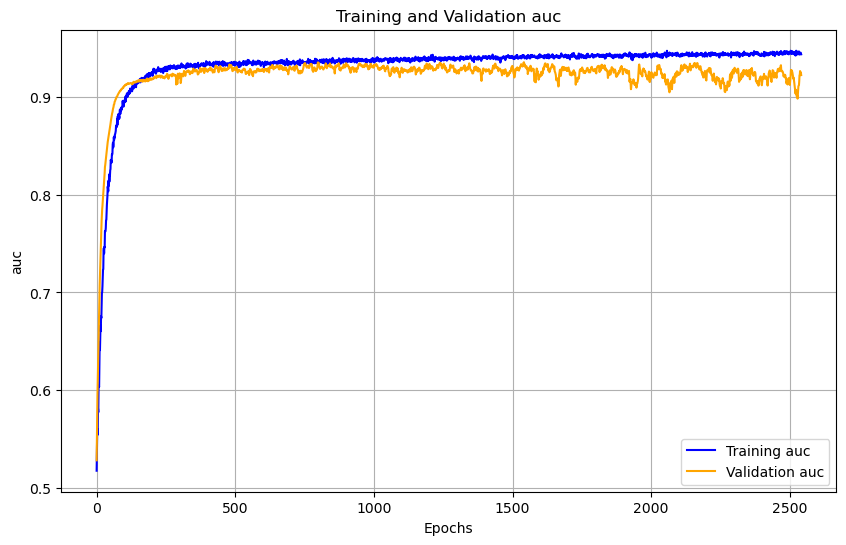

In [29]:
draw_metric(history, 'auc')

In [17]:
from sklearn.metrics import classification_report,  precision_score, recall_score, fbeta_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve

def get_classification_report(x, y_true, threshold=0.5):
 
    y_pred = model.predict(x, verbose=0)
    y_pred = ((y_pred >= threshold).astype(int).flatten())  # Convert probabilities to binary predictions

    return classification_report(y_true, y_pred)

def get_f2_score(x, y_true, beta = 2, threshold=0.5):
    y_pred = model.predict(x, verbose=0)
    y_pred = ((y_pred >= threshold).astype(int).flatten())  # Convert probabilities to binary predictions

    return fbeta_score(y_true, y_pred, beta=beta)

def get_precision(x, y_true, threshold=0.5):
    y_pred = model.predict(x, verbose=0)
    y_pred = ((y_pred >= threshold).astype(int).flatten())  # Convert probabilities to binary predictions

    return precision_score(y_true, y_pred)

def get_recall(x, y_true, threshold=0.5):
    y_pred = model.predict(x, verbose=0)
    y_pred = ((y_pred >= threshold).astype(int).flatten())  # Convert probabilities to binary predictions

    return recall_score(y_true, y_pred)

def get_auc(x, y_true):
    y_pred = model.predict(x, verbose=0)
    return roc_auc_score(y_true, y_pred)

def get_confusion_matrix(x, y_true, threshold=0.5):
    y_pred = model.predict(x, verbose=0)
    y_pred = ((y_pred >= threshold).astype(int).flatten())  
    cm = confusion_matrix(y_pred, y_true)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

def get_precision_recall_curve(x, y_true):
    y_pred = model.predict(x, verbose=0)
    # y_pred = ((y_pred >= threshold).astype(int).flatten())  
    ticks = np.linspace(0, 1, 50)
    plt.xticks(ticks)
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    # Find the index where precision and recall are closest
    
    plt.plot(thresholds, precision[:-1], label="Precision",)
    plt.plot(thresholds, recall[:-1], label="Recall")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.legend()
    plt.title("Precision-Recall vs. Threshold")
    plt.show()
    



<Figure size 1200x600 with 0 Axes>

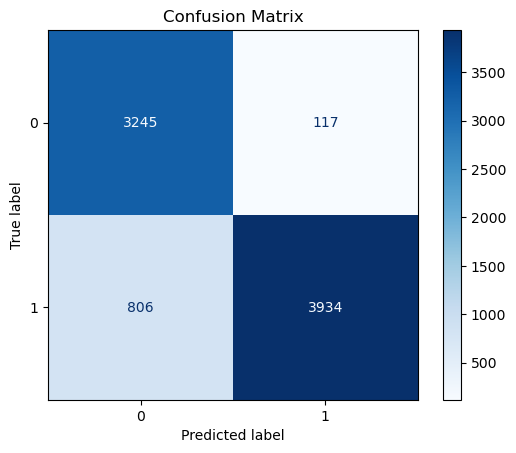

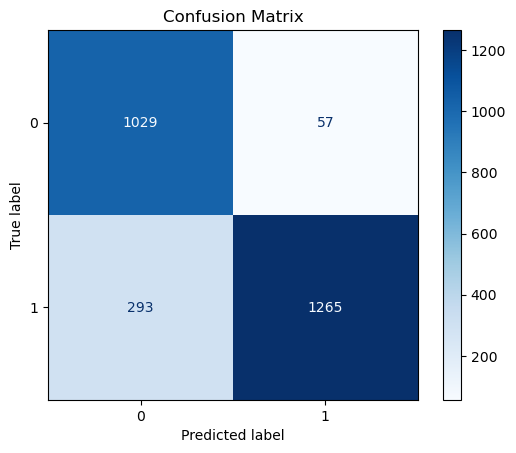

In [18]:

plt.figure(figsize=(12, 6))
x = x_train.astype(np.float32)
y = y_train.astype(np.float32)
get_confusion_matrix(x, y, THRESHOLD)

x = x_val.astype(np.float32)
y = y_val.astype(np.float32)
get_confusion_matrix(x, y, THRESHOLD)

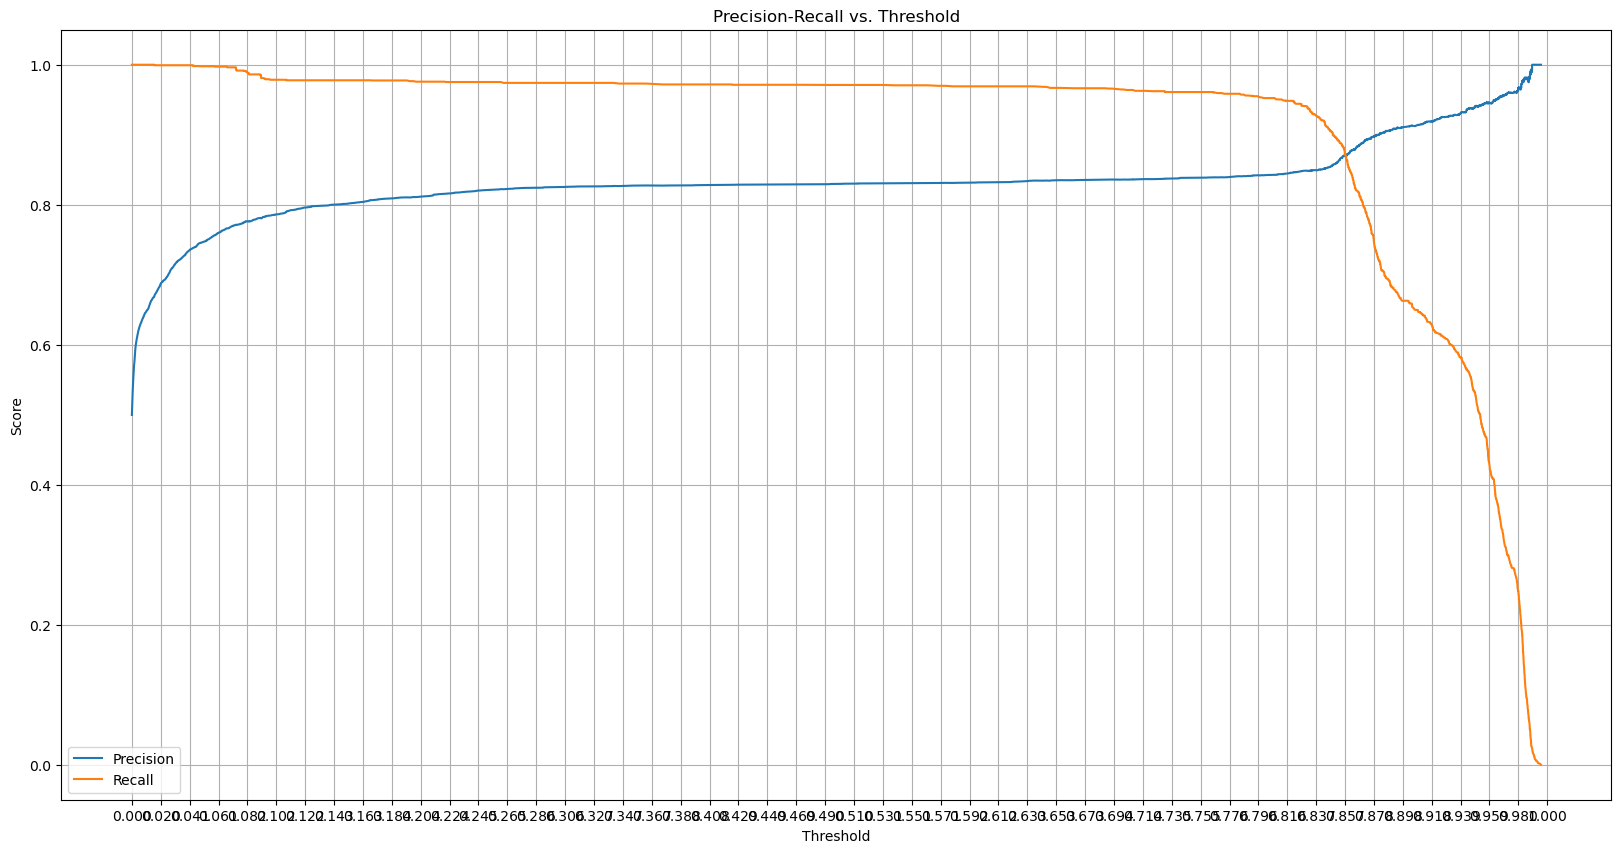

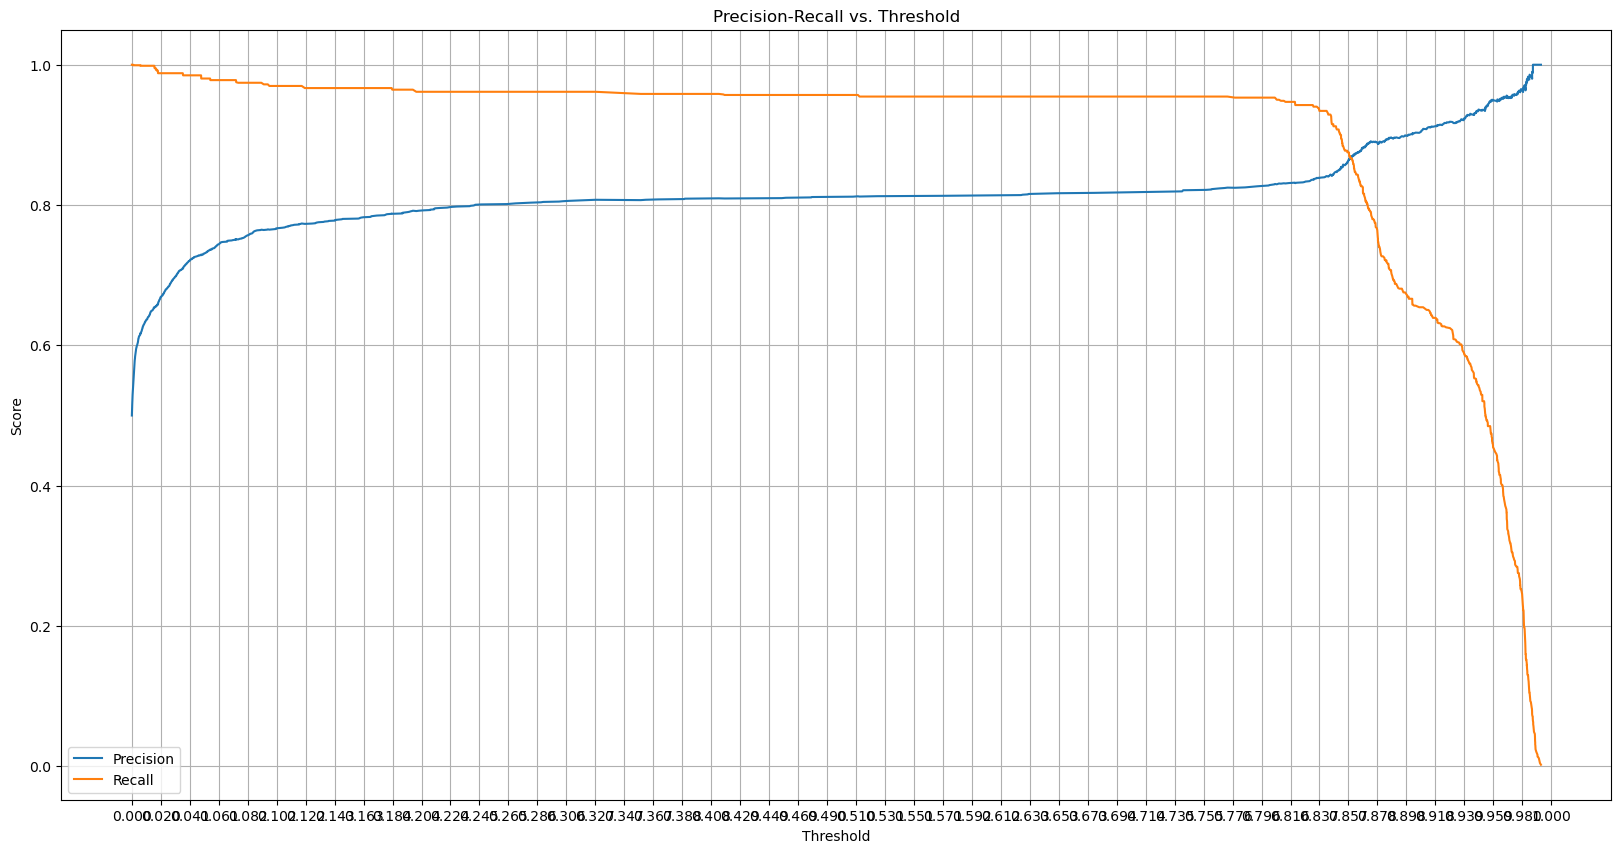

In [19]:

plt.figure(figsize=(20, 10))
plt.grid(True)
x = x_train.astype(np.float32)
y = y_train.astype(np.float32)
get_precision_recall_curve(x, y)
plt.figure(figsize=(20, 10))
x = x_val.astype(np.float32)
y = y_val.astype(np.float32)
plt.grid(True)
get_precision_recall_curve(x, y)


In [20]:
THRESHOLD = 0.81

In [21]:


x = x_train.astype(np.float32)
y = y_train.astype(np.float32)
fb = get_f2_score(x, y, beta=2, threshold = THRESHOLD, )
pr = get_precision(x, y, THRESHOLD)
re = get_recall(x, y, THRESHOLD)
auc = get_auc(x, y)
print("Training")
print("F2 Score: ", fb)
print("Precision: ", pr)
print("Recall: ", re)
print("AUC: ", auc)
print(get_classification_report(x, y, THRESHOLD))

print("*" * 100)

x = x_val.astype(np.float32)
y = y_val.astype(np.float32)
fb = get_f2_score(x, y, beta=2, threshold = THRESHOLD, )
pr = get_precision(x, y, THRESHOLD)
re = get_recall(x, y, THRESHOLD)
auc = get_auc(x, y)
print("Validation")
print("F2 Score: ", fb)
print("Precision: ", pr)
print("Recall: ", re)
print("AUC: ", auc)
print(get_classification_report(x, y, THRESHOLD))


Training
F2 Score:  0.926906779661017
Precision:  0.843558282208589
Recall:  0.9503826215749198
AUC:  0.943580006606705
              precision    recall  f1-score   support

         0.0       0.94      0.82      0.88      4051
         1.0       0.84      0.95      0.89      4051

    accuracy                           0.89      8102
   macro avg       0.89      0.89      0.89      8102
weighted avg       0.89      0.89      0.89      8102

****************************************************************************************************
Validation
F2 Score:  0.922465793732529
Precision:  0.831013916500994
Recall:  0.9485627836611196
AUC:  0.9354608727893601
              precision    recall  f1-score   support

         0.0       0.94      0.81      0.87      1322
         1.0       0.83      0.95      0.89      1322

    accuracy                           0.88      2644
   macro avg       0.89      0.88      0.88      2644
weighted avg       0.89      0.88      0.88      2644



83/83 [==============================] - 0s 2ms/step


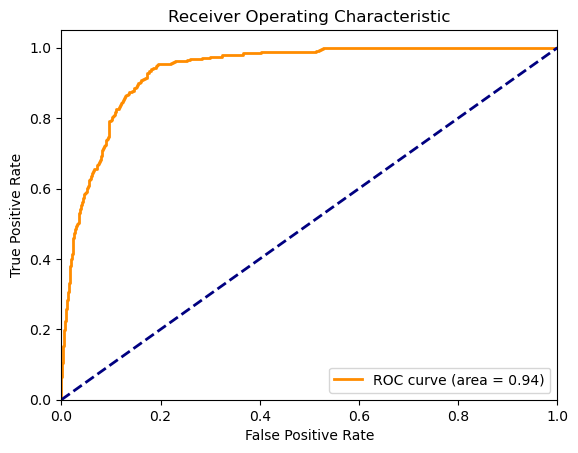

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming you have your model's predicted probabilities for the positive class
# Replace `model.predict_proba(x)[:, 1]` with your actual prediction method
y_pred_prob = model.predict(x)

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [23]:
# import shap
# # Create an explainer (for tree-based models)

# # Randomly select 100 indices from x_train
# x = x_train.astype(np.float32)
# indices = np.random.choice(400, size=1-0, replace=False)
# # Use these indices to select rows from x_train
# background = x_train[indices]

# explainer = shap.DeepExplainer(model, background)

# # Calculate SHAP values for the train set
# shap_values = explainer.shap_values(x_train)

In [24]:
# shap.summary_plot(shap_values.squeeze(axis=-1), features=Features, plot_type='bar', max_display=60)

In [25]:
# explainer = shap.KernelExplainer(model.predict, x_train[:100])  # Provide a background dataset (e.g., X_train)
# shap_values = explainer.shap_values(x_val[:1])  # Get SHAP values for the first instance in X_test

# # Convert the raw shap_values to an Explanation object
# shap_values_instance = shap.Explanation(values=shap_values[0], 
#                                          base_values=explainer.expected_value[0], 
#                                          data=x_val[:1])

In [26]:

# # Plot the waterfall chart for the first instance
# shap.plots.waterfall(shap_values_instance[:1, 0])

In [27]:
# shap_values_instance[:,0].shape